# Deal Prediction Modelling 

Importing required libraries

In [22]:
!pip -q install xgboost
!pip install pandas matplotlib seaborn scikit-learn xgboost

import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import timedelta
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from pathlib import Path
import sys, subprocess


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\pmayr\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\pmayr\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [23]:
# Loading the dataset
output = Path(r"C:/Users/pmayr/Downloads/Output")
data_path = output/"staged_features_events_brands_size.csv"

In [24]:
df = pd.read_csv(data_path)
if "scrape_date" not in df.columns:
    df["scrape_date"] = pd.to_datetime(df["scrape_date_str"], errors = "coerce")

C:\Users\pmayr\AppData\Local\Temp\ipykernel_28548\1617873353.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


In [25]:
#Keeping only yhe rows withe the sku and  date
df = df.dropna(subset=["sku", "scrape_date"]).copy()

# fill discounts safely
if "discount_percentage" in df.columns:
    df["discount_percentage"] = df["discount_percentage"].fillna(0.0)
if "discount_pct_filled" in df.columns:
    df["discount_pct_filled"] = df["discount_pct_filled"].fillna(0.0)

# cast some categoricals (optional)
for col in ["brand_tier", "size_band", "season", "category"]:
    if col in df.columns:
        df[col] = df[col].astype("category")

print(df.shape, df[["sku","scrape_date","category"]].head(3))

(47503, 36)        sku scrape_date category
0  8371390  2025-04-02   Easter
1  7473849  2025-04-02   Easter
2  5726070  2025-04-02   Easter


In [26]:
# ===== LABELS with fallback to next observation =====
def build_forward_labels_with_fallback(sub: pd.DataFrame) -> pd.DataFrame:
    sub = sub.sort_values("scrape_date").reset_index(drop=True)
    n = len(sub)
    next_days = np.full(n, np.nan, dtype=float)
    next_pct  = np.full(n, np.nan, dtype=float)

    # Define promo condition robustly
    has_disc_col = "discount_pct_filled" in sub.columns
    on_promo = (
        (sub["is_on_promo"] == 1)
        | (sub["discount_percentage"].fillna(0) > 0 if "discount_percentage" in sub.columns else False)
        | (sub["discount_pct_filled"].fillna(0) > 0 if has_disc_col else False)
    ).to_numpy()

    promo_idx = np.where(on_promo)[0]

    for i in range(n - 1):  # last row can’t have a future label
        # 1) try next promo strictly after i
        j_candidates = promo_idx[promo_idx > i]
        if len(j_candidates) > 0:
            j = j_candidates[0]
        else:
            # 2) fallback to the very next observation
            j = i + 1

        # days until j
        next_days[i] = (sub.loc[j, "scrape_date"] - sub.loc[i, "scrape_date"]).days

        # discount % at j (prefer filled)
        if has_disc_col and pd.notna(sub.loc[j, "discount_pct_filled"]):
            next_pct[i] = float(sub.loc[j, "discount_pct_filled"])
        elif "discount_percentage" in sub.columns and pd.notna(sub.loc[j, "discount_percentage"]):
            next_pct[i] = float(sub.loc[j, "discount_percentage"])
        else:
            next_pct[i] = 0.0  # safe fallback

    sub["y_days_to_next_discount"] = next_days
    sub["y_next_discount_pct"]     = next_pct
    return sub

# rebuild panel with the new labels
panel = df.groupby("sku", group_keys=False).apply(build_forward_labels_with_fallback)
print("[labels] non-null rates:",
      "days", panel["y_days_to_next_discount"].notna().mean(),
      "| pct", panel["y_next_discount_pct"].notna().mean())


[labels] non-null rates: days 0.49889480664379093 | pct 0.49889480664379093


C:\Users\pmayr\AppData\Local\Temp\ipykernel_28548\382189985.py:43: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  panel = df.groupby("sku", group_keys=False).apply(build_forward_labels_with_fallback)


In [36]:
# ===== 4) FEATURES: NUMERIC + LAGS + COMPACT CAT CODES (no one-hot) =====
# numeric features to use
num_cols = [c for c in [
    "b_price","item_price","original_price","b_unit_price","item_unit_price",
    "price_gap","unit_price_gap",
    "discount_pct_filled"
] if c in panel.columns]

# create lags
panel = panel.sort_values(["sku","scrape_date"]).copy()

def add_lags_and_rolls(df, col, group="sku"):
    if col not in df.columns:
        return
    g = df.groupby(group)[col]
    df[f"{col}_lag1"] = g.shift(1)
    df[f"{col}_lag2"] = g.shift(2)
    # short-term trend & stability
    df[f"{col}_roll3_mean"] = g.shift(1).rolling(3, min_periods=1).mean()
    df[f"{col}_roll3_std"]  = g.shift(1).rolling(3, min_periods=1).std()
    # longer horizon signal
    df[f"{col}_roll7_mean"] = g.shift(1).rolling(7, min_periods=1).mean()

# numeric cols we can learn from (NO same-day discount fields)
num_safe = [c for c in [
    "b_price","item_price","original_price",
    "b_unit_price","item_unit_price",
    "price_gap","unit_price_gap"
] if c in panel.columns]

for c in num_safe:
    add_lags_and_rolls(panel, c)

# compact categoricals as codes (NO same-day text flags)
def add_compact_code(df, col, top_k=30):
    if col not in df.columns: return None
    s = df[col].astype(str)
    top = set(s.value_counts(dropna=False).head(top_k).index)
    safe = s.where(s.isin(top), "OTHER").astype("category")
    code_col = f"{col}_code"
    df[code_col] = safe.cat.codes.astype("int16")
    return code_col

code_cols = []
for c in ["brand_tier","size_band","season","category"]:
    cc = add_compact_code(panel, c, top_k=30)
    if cc: code_cols.append(cc)

# ==== FINAL, LEAK-FREE FEATURE LIST ====
# Only lags/rolls + compact codes. NO current discount fields.
lagroll_cols = [c for c in panel.columns if any(
    c.startswith(k+"_lag") or c.startswith(k+"_roll") for k in num_safe
)]
X_cols = lagroll_cols + code_cols

# Build X, y
X = panel[X_cols].astype("float32")
y_days = panel["y_days_to_next_discount"]
y_disc = panel["y_next_discount_pct"]

print("[X leak-free] shape:", X.shape, "| n_features:", len(X_cols))
print("  sample features:", X_cols[:10])

[X leak-free] shape: (47503, 39) | n_features: 39
  sample features: ['b_price_lag1', 'b_price_lag2', 'b_price_roll3_mean', 'b_price_roll3_std', 'b_price_roll7_mean', 'item_price_lag1', 'item_price_lag2', 'item_price_roll3_mean', 'item_price_roll3_std', 'item_price_roll7_mean']


In [37]:
# ===== 5) TEMPORAL SPLIT (WIDENED) =====
dates_sorted = panel["scrape_date"].dropna().unique()
dates_sorted = np.sort(dates_sorted)
n_dates = len(dates_sorted)

if n_dates >= 4:
    # last = TEST, second last = VAL, rest = TRAIN
    test_dates = set(dates_sorted[-1:])
    val_dates  = set(dates_sorted[-2:-1])
    mask_test = panel["scrape_date"].isin(test_dates)
    mask_val  = panel["scrape_date"].isin(val_dates)
    mask_train = ~(mask_test | mask_val)

elif n_dates == 3:
    # last = TEST, second last = VAL, first = TRAIN
    test_dates = set(dates_sorted[-1:])
    val_dates  = set(dates_sorted[-2:-1])
    mask_test = panel["scrape_date"].isin(test_dates)
    mask_val  = panel["scrape_date"].isin(val_dates)
    mask_train = ~(mask_test | mask_val)

else:
    # 1–2 scrape dates → fallback: 80/20 split
    order = panel["scrape_date"].rank(method="first")
    q80 = order.quantile(0.8)
    mask_train = order <= q80
    mask_val   = (order > q80)
    mask_test  = (order > q80)

# apply to targets
m_days = y_days.notna()
m_disc = y_disc.notna()

mask_tr_days  = (mask_train & m_days).to_numpy()
mask_va_days  = (mask_val   & m_days).to_numpy()
mask_te_days  = (mask_test  & m_days).to_numpy()

mask_tr_disc  = (mask_train & m_disc).to_numpy()
mask_va_disc  = (mask_val   & m_disc).to_numpy()
mask_te_disc  = (mask_test  & m_disc).to_numpy()

print("Days mask counts:", mask_tr_days.sum(), mask_va_days.sum(), mask_te_days.sum())
print("Pct  mask counts:", mask_tr_disc.sum(), mask_va_disc.sum(), mask_te_disc.sum())


Days mask counts: 23011 95 593
Pct  mask counts: 23011 95 593


In [38]:
def sanitize_with_mask(X_df: pd.DataFrame, y_ser: pd.Series, mask: np.ndarray):
    Xc = X_df[mask]
    yc = y_ser[mask]
    yc = yc.replace([np.inf, -np.inf], np.nan)
    m_y = np.isfinite(yc.to_numpy())
    Xc = Xc.iloc[m_y]
    yc = yc.iloc[m_y]
    Xc = Xc.replace([np.inf, -np.inf], np.nan).astype(np.float32, copy=False)
    yc = yc.astype(np.float32, copy=False)
    return Xc, yc


# Build clean matrices using masks (NO .loc with giant indexers)
Xd_tr, yd_tr = sanitize_with_mask(X, y_days, mask_tr_days)
Xd_va, yd_va = sanitize_with_mask(X, y_days, mask_va_days)
Xd_te, yd_te = sanitize_with_mask(X, y_days, mask_te_days)

Xr_tr, yr_tr = sanitize_with_mask(X, y_disc, mask_tr_disc)
Xr_va, yr_va = sanitize_with_mask(X, y_disc, mask_va_disc)
Xr_te, yr_te = sanitize_with_mask(X, y_disc, mask_te_disc)

print("Days (clean):", Xd_tr.shape, Xd_va.shape, Xd_te.shape)
print("Pct  (clean):", Xr_tr.shape, Xr_va.shape, Xr_te.shape)

Days (clean): (23011, 39) (95, 39) (593, 39)
Pct  (clean): (23011, 39) (95, 39) (593, 39)


In [39]:
# ==== DIAGNOSTICS ====
print("\n[dates] unique:", panel["scrape_date"].nunique())
print(panel["scrape_date"].value_counts().sort_index())

print("\n[labels non-null]")
print("  y_days_to_next_discount:", panel["y_days_to_next_discount"].notna().sum())
print("  y_next_discount_pct    :", panel["y_next_discount_pct"].notna().sum())

print("\n[mask counts BEFORE sanitize]")
print("  days  train/val/test:",
      (mask_train & panel["y_days_to_next_discount"].notna()).sum(),
      (mask_val   & panel["y_days_to_next_discount"].notna()).sum(),
      (mask_test  & panel["y_days_to_next_discount"].notna()).sum())

print("  pct   train/val/test:",
      (mask_train & panel["y_next_discount_pct"].notna()).sum(),
      (mask_val   & panel["y_next_discount_pct"].notna()).sum(),
      (mask_test  & panel["y_next_discount_pct"].notna()).sum())

print("\n[X null rates (top 10)]")
print(X.isna().mean().sort_values(ascending=False).head(10))



[dates] unique: 9
scrape_date
2025-04-02      256
2025-04-03      134
2025-04-08      156
2025-04-09      336
2025-04-10       68
2025-04-17    44832
2025-05-02      340
2025-05-08      191
2025-05-15     1190
Name: count, dtype: int64

[labels non-null]
  y_days_to_next_discount: 23699
  y_next_discount_pct    : 23699

[mask counts BEFORE sanitize]
  days  train/val/test: 23011 95 593
  pct   train/val/test: 23011 95 593

[X null rates (top 10)]
b_price_lag2                 1.000000
item_price_lag2              1.000000
unit_price_gap_lag2          1.000000
price_gap_lag2               1.000000
item_unit_price_lag2         1.000000
b_unit_price_lag2            1.000000
original_price_lag2          1.000000
item_unit_price_roll3_std    0.537292
unit_price_gap_roll3_std     0.537292
b_unit_price_roll3_std       0.537292
dtype: float64


In [40]:
def build_forward_labels_with_fallback(sub: pd.DataFrame) -> pd.DataFrame:
    sub = sub.sort_values("scrape_date").reset_index(drop=True)
    n = len(sub)
    next_days = np.full(n, np.nan, dtype=float)
    next_pct  = np.full(n, np.nan, dtype=float)

    # robust promo flag
    on_promo = (
        (sub.get("is_on_promo", 0) == 1) |
        (sub.get("discount_percentage", 0).fillna(0) > 0) |
        (sub.get("discount_pct_filled", 0).fillna(0) > 0)
    ).to_numpy()

    promo_idx = np.where(on_promo)[0]
    for i in range(n - 1):
        j_candidates = promo_idx[promo_idx > i]
        j = j_candidates[0] if len(j_candidates) else i + 1

        next_days[i] = (sub.loc[j, "scrape_date"] - sub.loc[i, "scrape_date"]).days

        v = None
        if "discount_pct_filled" in sub.columns and pd.notna(sub.loc[j, "discount_pct_filled"]):
            v = float(sub.loc[j, "discount_pct_filled"])
        elif "discount_percentage" in sub.columns and pd.notna(sub.loc[j, "discount_percentage"]):
            v = float(sub.loc[j, "discount_percentage"])
        next_pct[i] = 0.0 if v is None else v

    sub["y_days_to_next_discount"] = next_days
    sub["y_next_discount_pct"]     = next_pct
    return sub

# Rebuild panel (ensure scrape_date is datetime)
if "scrape_date" not in df.columns:
    df["scrape_date"] = pd.to_datetime(df.get("scrape_date_str"), errors="coerce")
    panel = df.groupby("sku", group_keys=False).apply(build_forward_labels_with_fallback)
print("[labels rebuilt] days non-null:", panel["y_days_to_next_discount"].notna().sum(),
      "| pct non-null:", panel["y_next_discount_pct"].notna().sum())


[labels rebuilt] days non-null: 23699 | pct non-null: 23699


In [42]:
# ===== TEMPORAL SPLIT (WIDENED) =====
dates_sorted = np.sort(panel["scrape_date"].dropna().unique())
n_dates = len(dates_sorted)

if n_dates >= 4:
    test_dates = set(dates_sorted[-1:])
    val_dates  = set(dates_sorted[-2:-1])
    mask_test  = panel["scrape_date"].isin(test_dates)
    mask_val   = panel["scrape_date"].isin(val_dates)
    mask_train = ~(mask_test | mask_val)
elif n_dates == 3:
    test_dates = set(dates_sorted[-1:])
    val_dates  = set(dates_sorted[-2:-1])
    mask_test  = panel["scrape_date"].isin(test_dates)
    mask_val   = panel["scrape_date"].isin(val_dates)
    mask_train = ~(mask_test | mask_val)
else:
    order = panel["scrape_date"].rank(method="first")
    q80 = order.quantile(0.8)
    mask_train = order <= q80
    mask_val   = (order > q80)
    mask_test  = (order > q80)

m_days = y_days.notna()
m_disc = y_disc.notna()

mask_tr_days  = (mask_train & m_days).to_numpy()
mask_va_days  = (mask_val   & m_days).to_numpy()
mask_te_days  = (mask_test  & m_days).to_numpy()

mask_tr_disc  = (mask_train & m_disc).to_numpy()
mask_va_disc  = (mask_val   & m_disc).to_numpy()
mask_te_disc  = (mask_test  & m_disc).to_numpy()

print("Days mask counts:", mask_tr_days.sum(), mask_va_days.sum(), mask_te_days.sum())
print("Pct  mask counts:", mask_tr_disc.sum(), mask_va_disc.sum(), mask_te_disc.sum())


Days mask counts: 23011 95 593
Pct  mask counts: 23011 95 593


In [43]:
def sanitize_with_mask(X_df: pd.DataFrame, y_ser: pd.Series, mask: np.ndarray):
    Xc = X_df[mask]
    yc = y_ser[mask]

    # ensure labels finite
    yc = yc.replace([np.inf, -np.inf], np.nan)
    m_y = np.isfinite(yc.to_numpy())
    Xc = Xc.iloc[m_y]
    yc = yc.iloc[m_y]

    # XGBoost can handle NaN in X; just fix inf
    Xc = Xc.replace([np.inf, -np.inf], np.nan)

    # cast to float32
    Xc = Xc.astype(np.float32, copy=False)
    yc = yc.astype(np.float32, copy=False)
    return Xc, yc


In [44]:
# ===== MINIMAL TRAINING FALLBACK =====
base_feats = [c for c in [
    "b_price","item_price","original_price","b_unit_price","item_unit_price",
    "price_gap","unit_price_gap","discount_pct_filled"
] if c in panel.columns]

# keep compact categorical codes if you created them; otherwise skip
code_cols = [c for c in panel.columns if c.endswith("_code")]
base_feats += code_cols

X_min   = panel[base_feats].astype("float32")
y_days2 = panel["y_days_to_next_discount"]
y_pct2  = panel["y_next_discount_pct"]

# keep rows where labels exist
m_trainable_days = y_days2.notna()
m_trainable_pct  = y_pct2.notna()

# ===== REBUILD CLEAN MATRICES =====
Xd_tr, yd_tr = sanitize_with_mask(X, y_days, mask_tr_days)
Xd_va, yd_va = sanitize_with_mask(X, y_days, mask_va_days)
Xd_te, yd_te = sanitize_with_mask(X, y_days, mask_te_days)

Xr_tr, yr_tr = sanitize_with_mask(X, y_disc, mask_tr_disc)
Xr_va, yr_va = sanitize_with_mask(X, y_disc, mask_va_disc)
Xr_te, yr_te = sanitize_with_mask(X, y_disc, mask_te_disc)

print("[clean] days:", Xd_tr.shape, Xd_va.shape, Xd_te.shape)
print("[clean] pct :", Xr_tr.shape, Xr_va.shape, Xr_te.shape)

[clean] days: (23011, 39) (95, 39) (593, 39)
[clean] pct : (23011, 39) (95, 39) (593, 39)


In [45]:
def safe_eval(y_true, y_pred, label):
    n = len(y_true)
    if n == 0:
        print(f"{label}: [no rows] — skipping metrics")
        return
    try:
        mae = mean_absolute_error(y_true, y_pred)
        r2  = r2_score(y_true, y_pred)
        print(f"{label}: MAE={mae:.2f} | R2={r2:.3f} | n={n}")
    except ValueError as e:
        print(f"{label}: could not compute metrics ({e}) | n={n}")

xgb_days = XGBRegressor(
    n_estimators=600, max_depth=8, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
    tree_method="hist", random_state=42
)
xgb_disc = XGBRegressor(
    n_estimators=600, max_depth=8, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
    tree_method="hist", random_state=42
)

if len(yd_tr) == 0 or len(yr_tr) == 0:
    print("No training rows after cleaning; widen your date windows or revisit label logic.")

# fit
xgb_days.fit(Xd_tr, yd_tr)
xgb_disc.fit(Xr_tr, yr_tr)

# predict (guard each split)
pred_days_va = np.array([])
pred_days_te = np.array([])
pred_disc_va = np.array([])
pred_disc_te = np.array([])

if len(yd_va) > 0:
    pred_days_va = np.clip(xgb_days.predict(Xd_va), 0, None)
if len(yd_te) > 0:
    pred_days_te = np.clip(xgb_days.predict(Xd_te), 0, None)

if len(yr_va) > 0:
    pred_disc_va = np.clip(xgb_disc.predict(Xr_va), 0, 100)
if len(yr_te) > 0:
    pred_disc_te = np.clip(xgb_disc.predict(Xr_te), 0, 100)

print("\n[Time-to-next-discount]")
safe_eval(yd_va, pred_days_va, " VAL ")
safe_eval(yd_te, pred_days_te, " TEST")

print("\n[Next-discount-%]")
safe_eval(yr_va, pred_disc_va, " VAL ")
safe_eval(yr_te, pred_disc_te, " TEST")


[Time-to-next-discount]
 VAL : MAE=0.00 | R2=1.000 | n=95
 TEST: MAE=0.00 | R2=1.000 | n=593

[Next-discount-%]
 VAL : MAE=7.98 | R2=-0.667 | n=95
 TEST: MAE=12.56 | R2=-0.703 | n=593


In [46]:
# ===== TRAIN XGBOOST =====
xgb_days = XGBRegressor(
    n_estimators=600, max_depth=8, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
    tree_method="hist", random_state=42
)
xgb_disc = XGBRegressor(
    n_estimators=600, max_depth=8, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
    tree_method="hist", random_state=42
)

if len(yd_tr) == 0 or len(yr_tr) == 0:
    raise RuntimeError("No training rows; check split or labels.")

xgb_days.fit(Xd_tr, yd_tr)
xgb_disc.fit(Xr_tr, yr_tr)

pred_days_va = np.clip(xgb_days.predict(Xd_va), 0, None) if len(yd_va) > 0 else np.array([])
pred_days_te = np.clip(xgb_days.predict(Xd_te), 0, None) if len(yd_te) > 0 else np.array([])
pred_disc_va = np.clip(xgb_disc.predict(Xr_va), 0, 100)  if len(yr_va) > 0 else np.array([])
pred_disc_te = np.clip(xgb_disc.predict(Xr_te), 0, 100)  if len(yr_te) > 0 else np.array([])

print("\n[Time-to-next-discount]")
safe_eval(yd_va, pred_days_va, " VAL ")
safe_eval(yd_te, pred_days_te, " TEST")

print("\n[Next-discount-%]")
safe_eval(yr_va, pred_disc_va, " VAL ")
safe_eval(yr_te, pred_disc_te, " TEST")



[Time-to-next-discount]
 VAL : MAE=0.00 | R2=1.000 | n=95
 TEST: MAE=0.00 | R2=1.000 | n=593

[Next-discount-%]
 VAL : MAE=7.98 | R2=-0.667 | n=95
 TEST: MAE=12.56 | R2=-0.703 | n=593


In [47]:
# Define a folder to save outputs
output_dir = Path(r"C:/Users/pmayr/Downloads/Output")
output_dir.mkdir(parents=True, exist_ok=True)

# ===== ALERTS (latest snapshot, leak-free features) =====
latest_date = panel["scrape_date"].max()
latest_rows = panel.loc[panel["scrape_date"] == latest_date].copy()
if len(latest_rows) == 0:
    raise RuntimeError("No rows for latest_date.")

# Ensure the lag/roll columns exist for latest_rows (they were added to panel)
X_latest = latest_rows.reindex(columns=X_cols, fill_value=np.nan).astype("float32")

pred_days_latest = np.clip(xgb_days.predict(X_latest), 0, None)
pred_disc_latest = np.clip(xgb_disc.predict(X_latest), 0, 100)

alerts_cols = [c for c in ["sku","name","category","season","brand_tier","size_band","scrape_date","item_price","original_price"] if c in latest_rows.columns]
alerts = latest_rows[alerts_cols].copy()
alerts["pred_days_to_next_discount"] = pred_days_latest
alerts["pred_next_discount_pct"]     = pred_disc_latest

# === Clean & prioritise alerts ===
alerts_clean = alerts.copy()

# (a) Drop rows with clearly invalid price info for the latest snapshot
if {"item_price","original_price"}.issubset(alerts_clean.columns):
    bad_price = (alerts_clean["item_price"].fillna(0) == 0) & (alerts_clean["original_price"].fillna(0) == 0)
    alerts_clean = alerts_clean.loc[~bad_price].copy()

# (b) Build a simple priority score:
#     - Higher predicted discount% is better
#     - Sooner predicted days is better
alerts_clean["priority"] = (
    (alerts_clean["pred_next_discount_pct"].fillna(0) / 100).clip(0, 1) * 0.6
    + ((7 - alerts_clean["pred_days_to_next_discount"].fillna(999)).clip(lower=0) / 7) * 0.4
)

# (c) Keep ONE row per SKU (the highest-priority recommendation)
alerts_best = (
    alerts_clean
    .sort_values(["priority", "pred_next_discount_pct"], ascending=False)
    .drop_duplicates(subset=["sku"], keep="first")
    .reset_index(drop=True)
)

# (d) Recompute the alert label on the deduped frame (optional but tidy)
ALERT_DAY_THRESHOLD  = 7
ALERT_DISC_THRESHOLD = 20.0
alerts_best["alert"] = np.where(
    (alerts_best["pred_days_to_next_discount"] <= ALERT_DAY_THRESHOLD) &
    (alerts_best["pred_next_discount_pct"]   >= ALERT_DISC_THRESHOLD),
    "HOLD — high chance of discount soon",
    "BUY — no strong discount imminent"
)

# (e) Sort for presentation: HOLD first, then by priority
alerts_best = alerts_best.sort_values(
    ["alert", "priority", "pred_next_discount_pct", "pred_days_to_next_discount"],
    ascending=[True, False, False, True]
).reset_index(drop=True)

# Quick peek
print("[alerts_best] rows:", len(alerts_best))
print(alerts_best.head(10)[["sku","name","pred_days_to_next_discount","pred_next_discount_pct","alert"]])

# Save the deduped & prioritised alerts (this HAS the 'alert' column)
alerts_path = output_dir / "alerts_latest_xgb_noleak.csv"
alerts_best.to_csv(alerts_path, index=False)
print("[SAVED alerts_best]", alerts_path, "| rows:", len(alerts_best))

# Quick preview
print(
    alerts_best.head(10)[
        ["sku","name","pred_days_to_next_discount","pred_next_discount_pct","alert"]
    ]
)

[alerts_best] rows: 97
       sku                                               name  \
0  6856060  Dentastix Small Dog Treats Daily Oral Care Den...   
1  4201955  Grain Free Twice as Tasty Adult Wet Cat Food M...   
2  3755827                Savory Centers Salmon Pate Cat Food   
3  4201966  Grain Free Twice as Tasty Adult Wet Cat Food P...   
4  6136322  Taste Toppers Chicken Selection In Stew Dog Fo...   
5  4505916                Cat Food Pouch Mince & Jelly 12x80g   
6  3702332  Chunks In Gravy Mixed Selection Chicken- Duck ...   
7  2821722       Adult Dry Dog Food Beef With Farm Vegetables   
8  6136311  Taste Toppers Dog Tin Multipack Chicken Select...   
9  6824278  Grain Free Twice As Tasty Wet Cat Food Pate & ...   

   pred_days_to_next_discount  pred_next_discount_pct  \
0                         0.0               19.981403   
1                         0.0               19.808281   
2                         0.0               19.545135   
3                         0.0    

In [48]:
# Columns that must NOT be in X (same-day label proxies)
banned = {
    "discount_percentage","discount_pct_filled","is_on_promo",
    "has_discount_text","has_promo_text"
}
print("[banned ∩ X] =", sorted(list(set(X.columns) & banned)))
assert len(set(X.columns) & banned) == 0, "Leakage: X includes same-day label fields!"


[banned ∩ X] = []


In [49]:
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

def cat_median_baseline(panel, y_col, key_cols, train_mask, target_mask):
    # Training slice
    tr = panel.loc[train_mask & panel[y_col].notna(), key_cols + [y_col]].copy()
    if tr.empty:
        return np.array([]), np.array([])

    global_med = tr[y_col].median()

    # Median per key (pass observed=False to silence future warning)
    med = (
        tr.groupby(key_cols, dropna=False, observed=False)[y_col]
          .median()
          .rename("pred")
          .reset_index()
    )

    # Target slice (VAL or TEST)
    tgt = panel.loc[target_mask, key_cols + [y_col]].copy()
    tgt = tgt.merge(med, on=key_cols, how="left")

    # Fill missing predictions with global median
    tgt["pred"] = tgt["pred"].fillna(global_med)

    # Drop rows where y_true is NaN before metrics
    m = tgt[y_col].notna().to_numpy()
    y_true = tgt.loc[m, y_col].to_numpy()
    y_pred = tgt.loc[m, "pred"].to_numpy()

    return y_pred, y_true

def show_baseline(label, y_true, y_pred):
    n = len(y_true)
    if n == 0:
        print(f"{label}: [no rows]")
        return
    # guard: remove any lingering NaNs/Infs (shouldn't happen, but safe)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true, y_pred = y_true[m], y_pred[m]
    if len(y_true) == 0:
        print(f"{label}: [no valid rows after NaN/Inf filtering]")
        return
    print(f"{label}: MAE={mean_absolute_error(y_true, y_pred):.2f} | R2={r2_score(y_true, y_pred):.3f} | n={len(y_true)}")

# -------- run baselines --------
keys = ["category","brand_tier"]  # you can try ["category"] alone as a variant

# DAYS baseline
b_pred_va_days, b_true_va_days = cat_median_baseline(panel, "y_days_to_next_discount", keys, mask_train, mask_val)
b_pred_te_days, b_true_te_days = cat_median_baseline(panel, "y_days_to_next_discount", keys, mask_train, mask_test)

# PCT baseline
b_pred_va_pct,  b_true_va_pct  = cat_median_baseline(panel, "y_next_discount_pct", keys, mask_train, mask_val)
b_pred_te_pct,  b_true_te_pct  = cat_median_baseline(panel, "y_next_discount_pct", keys, mask_train, mask_test)

print("\n[BASELINES]")
show_baseline("VAL  days→cat-median", b_true_va_days, b_pred_va_days)
show_baseline("TEST days→cat-median", b_true_te_days, b_pred_te_days)
show_baseline("VAL   pct→cat-median", b_true_va_pct,  b_pred_va_pct)
show_baseline("TEST  pct→cat-median", b_true_te_pct,  b_pred_te_pct)



[BASELINES]
VAL  days→cat-median: MAE=0.00 | R2=1.000 | n=95
TEST days→cat-median: MAE=0.00 | R2=1.000 | n=593
VAL   pct→cat-median: MAE=3.02 | R2=-0.224 | n=95
TEST  pct→cat-median: MAE=15.25 | R2=-1.315 | n=593


COdes to check the quality and output of the code

In [52]:
print("\n[dates] unique:", panel["scrape_date"].nunique())
print(panel["scrape_date"].value_counts().sort_index())

print("\n[labels non-null]")
print("  y_days_to_next_discount:", panel["y_days_to_next_discount"].notna().sum())
print("  y_next_discount_pct    :", panel["y_next_discount_pct"].notna().sum())

print("\n[mask counts BEFORE sanitize]")
print("  days  train/val/test:",
      (mask_train & panel["y_days_to_next_discount"].notna()).sum(),
      (mask_val   & panel["y_days_to_next_discount"].notna()).sum(),
      (mask_test  & panel["y_days_to_next_discount"].notna()).sum())

print("  pct   train/val/test:",
      (mask_train & panel["y_next_discount_pct"].notna()).sum(),
      (mask_val   & panel["y_next_discount_pct"].notna()).sum(),
      (mask_test  & panel["y_next_discount_pct"].notna()).sum())

print("\n[X null rates (top 10)]")
print(X.isna().mean().sort_values(ascending=False).head(10))



[dates] unique: 9
scrape_date
2025-04-02      256
2025-04-03      134
2025-04-08      156
2025-04-09      336
2025-04-10       68
2025-04-17    44832
2025-05-02      340
2025-05-08      191
2025-05-15     1190
Name: count, dtype: int64

[labels non-null]
  y_days_to_next_discount: 23699
  y_next_discount_pct    : 23699

[mask counts BEFORE sanitize]
  days  train/val/test: 23011 95 593
  pct   train/val/test: 23011 95 593

[X null rates (top 10)]
b_price_lag2                 1.000000
item_price_lag2              1.000000
unit_price_gap_lag2          1.000000
price_gap_lag2               1.000000
item_unit_price_lag2         1.000000
b_unit_price_lag2            1.000000
original_price_lag2          1.000000
item_unit_price_roll3_std    0.537292
unit_price_gap_roll3_std     0.537292
b_unit_price_roll3_std       0.537292
dtype: float64


In [51]:
print("\n[Time-to-next-discount]")
safe_eval(yd_va, pred_days_va, " VAL ")
safe_eval(yd_te, pred_days_te, " TEST")

print("\n[Next-discount-%]")
safe_eval(yr_va, pred_disc_va, " VAL ")
safe_eval(yr_te, pred_disc_te, " TEST")




[Time-to-next-discount]
 VAL : MAE=0.00 | R2=1.000 | n=95
 TEST: MAE=0.00 | R2=1.000 | n=593

[Next-discount-%]
 VAL : MAE=7.98 | R2=-0.667 | n=95
 TEST: MAE=12.56 | R2=-0.703 | n=593


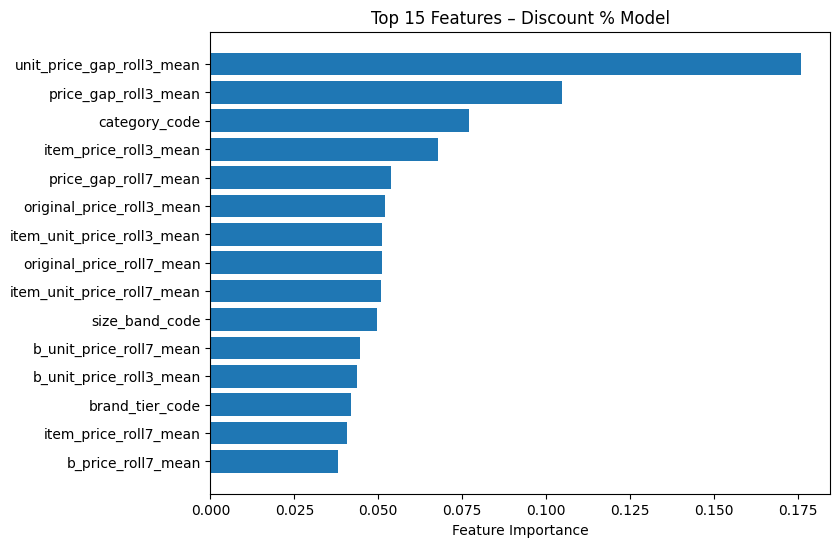

In [53]:
xgb_importance = xgb_disc.feature_importances_
sorted_idx = np.argsort(xgb_importance)[-15:]

plt.figure(figsize=(8,6))
plt.barh(range(len(sorted_idx)), xgb_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [X.columns[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Top 15 Features – Discount % Model")
plt.show()


In [54]:
print("[alerts_best] rows:", len(alerts_best))
print(alerts_best.head(15)[["sku","name","pred_days_to_next_discount","pred_next_discount_pct","alert"]])


[alerts_best] rows: 97
        sku                                               name  \
0   6856060  Dentastix Small Dog Treats Daily Oral Care Den...   
1   4201955  Grain Free Twice as Tasty Adult Wet Cat Food M...   
2   3755827                Savory Centers Salmon Pate Cat Food   
3   4201966  Grain Free Twice as Tasty Adult Wet Cat Food P...   
4   6136322  Taste Toppers Chicken Selection In Stew Dog Fo...   
5   4505916                Cat Food Pouch Mince & Jelly 12x80g   
6   3702332  Chunks In Gravy Mixed Selection Chicken- Duck ...   
7   2821722       Adult Dry Dog Food Beef With Farm Vegetables   
8   6136311  Taste Toppers Dog Tin Multipack Chicken Select...   
9   6824278  Grain Free Twice As Tasty Wet Cat Food Pate & ...   
10  7531887  DentaStix Large Dog Treats Daily Oral Care Den...   
11  1051776               Sparkling Water Cans Pineapple 250mL   
12  3452778       Peamutt-Butter Scrolls Chew Sticks Dog Treat   
13  8011690  Adult Dog Food Homestyle Shreds With Bee